# Knowledge Distillation

This notebook shows how to perform a model compression technique knowledge distillation in which a *student* model "learns" from a more complex model *teacher*.
In particular:
*   Defining a Distiller class with the custom logic for distillation process
*   Training the teacher model which is a CNN that implements regularization via dropout
*   Training a student model (a smaller version of the teacher without regularization) by using knowledge distillation
*   Comparing the three students

Notebook is base on [this](https://keras.io/examples/vision/knowledge_distillation/) official Keras tutorial.

In [1]:
DATASET_PATH = '/usr/local/lib/python3.7/dist-packages/tensorflow_datasets/image_classification/cats_vs_dogs.py'
!sed -i 's/3367a/5340/g' {DATASET_PATH}

sed: can't read /usr/local/lib/python3.7/dist-packages/tensorflow_datasets/image_classification/cats_vs_dogs.py: No such file or directory


In [2]:
# For setting random seeds
import os
os.environ['PYTHONHASHSEED']=str(42)

# Libraries
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# More random seed setup
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

We will use [cats vs dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) dataset which is composed of images of cats and dogs and their respective labels.

In [3]:
# Define train/test splits
splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']

# Download the dataset
(train_examples, validation_examples, test_examples), info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split=splits)

# Print useful information
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

print(f"There are {num_examples} images for {num_classes} classes.")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.HBRPOI_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
There are 23262 images for 2 classes.


In [4]:
# Some global variables
pixels = 224
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 32

# Apply resizing and pixel normalization
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return  image, label

# Create batches of data
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

### Custom Distiller Model

In order to implement distillation process we need to create a custom Keras model named Distiller. We need to override some of the vanilla methods of a keras.Model to include custom logic for knowledge distillation. We will override these methods:
*   compile: This model needs some extra parameters to be compiled such as the teacher and student losses, the alpha and the temperature.
*   train_step: Controls how the model is trained. This will be where the actual knowledge distillation logic will be found. This method is what is called when you do model.fit
*   test_step: Controls the evaluation of the model. This method is what is called when you do model.evaluate

In [5]:
class Distiller(keras.Model):

  # Needs both the student and teacher models to create an instance of this class
  def __init__(self, student, teacher):
      super(Distiller, self).__init__()
      self.teacher = teacher
      self.student = student


  # Will be used when calling model.compile()
  def compile(self, optimizer, metrics, student_loss_fn,
              distillation_loss_fn, alpha, temperature):

      # Compile using the optimizer and metrics
      super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)

      # Add the other params to the instance
      self.student_loss_fn = student_loss_fn
      self.distillation_loss_fn = distillation_loss_fn
      self.alpha = alpha
      self.temperature = temperature


  # Will be used when calling model.fit()
  def train_step(self, data):
      # Data is expected to be a tuple of (features, labels)
      x, y = data

      # Vanilla forward pass of the teacher
      # Note that the teacher is NOT trained
      teacher_predictions = self.teacher(x, training=False)

      # Use GradientTape to save gradients
      with tf.GradientTape() as tape:
          # Vanilla forward pass of the student
          student_predictions = self.student(x, training=True)

          # Compute vanilla student loss
          student_loss = self.student_loss_fn(y, student_predictions)

          # Compute distillation loss
          # Should be KL divergence between logits softened by a temperature factor
          distillation_loss = self.distillation_loss_fn(
              tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
              tf.nn.softmax(student_predictions / self.temperature, axis=1))

          # Compute loss by weighting the two previous losses using the alpha param
          loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

      # Use tape to calculate gradients for student
      trainable_vars = self.student.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      # Update student weights
      # Note that this done ONLY for the student
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update the metrics
      self.compiled_metrics.update_state(y, student_predictions)

      # Return a performance dictionary
      # You will see this being outputted during training
      results = {m.name: m.result() for m in self.metrics}
      results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
      return results


  # Will be used when calling model.evaluate()
  def test_step(self, data):
      # Data is expected to be a tuple of (features, labels)
      x, y = data

      # Use student to make predictions
      # Notice that the training param is set to False
      y_prediction = self.student(x, training=False)

      # Calculate student's vanilla loss
      student_loss = self.student_loss_fn(y, y_prediction)

      # Update the metrics
      self.compiled_metrics.update_state(y, y_prediction)

      # Return a performance dictionary
      # You will see this being outputted during inference
      results = {m.name: m.result() for m in self.metrics}
      results.update({"student_loss": student_loss})
      return results

### Teacher and Student Models

For the models we will use a standard CNN architecture that implements regularization via some dropout layers (in the case of the teacher) but it could be any Keras model.

In [6]:
# Teacher model
def create_big_model():
  tf.random.set_seed(42)
  model = keras.models.Sequential([
      keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
      keras.layers.MaxPooling2D((2,2)),
      keras.layers.Conv2D(64, (3,3), activation='relu'),
      keras.layers.MaxPooling2D((2,2)),
      keras.layers.Dropout(0.2),
      keras.layers.Conv2D(64, (3,3), activation='relu'),
      keras.layers.MaxPooling2D((2,2)),
      keras.layers.Dropout(0.2),
      keras.layers.Conv2D(128, (3,3), activation='relu'),
      keras.layers.MaxPooling2D((2,2)),
      keras.layers.Dropout(0.5),
      keras.layers.Flatten(),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dense(2)
  ])

  return model

# Student model
def create_small_model():
  tf.random.set_seed(42)
  model = keras.models.Sequential([
      keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
      keras.layers.MaxPooling2D((2,2)),
      keras.layers.Flatten(),
      keras.layers.Flatten(),
      keras.layers.Dense(2)
  ])

  return model

In [ ]:
# Create the teacher
teacher = create_big_model()

# Plot architecture
keras.utils.plot_model(teacher, rankdir='LR')

In [ ]:
# Create the student
student = create_small_model()

# Plot achitecture
keras.utils.plot_model(student, rankdir='LR')

In [9]:
# Calculate number of trainable parameters for a given model
def num_trainable_params(model):
  return np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])

student_params = num_trainable_params(student)
teacher_params = num_trainable_params(teacher)

print(f"Student params: {student_params}")
print(f"Teacher params: {teacher_params}")
print(f"Teacher model is {teacher_params//student_params} times bigger than the student model")

Student params: 789442
Teacher params: 9568898
Teacher model is 12 times bigger than the student model


In [10]:
# Compile the teacher model
teacher.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Fit the model and save the training history
teacher_history = teacher.fit(train_batches, epochs=8, validation_data=validation_batches)

Epoch 1/8
582/582 [==============================] - 234s 398ms/step - loss: 0.6812 - sparse_categorical_accuracy: 0.5606 - val_loss: 0.6394 - val_sparse_categorical_accuracy: 0.6513
Epoch 2/8
582/582 [==============================] - 228s 390ms/step - loss: 0.5648 - sparse_categorical_accuracy: 0.7085 - val_loss: 0.4917 - val_sparse_categorical_accuracy: 0.7584
Epoch 3/8
582/582 [==============================] - 224s 385ms/step - loss: 0.4766 - sparse_categorical_accuracy: 0.7712 - val_loss: 0.4303 - val_sparse_categorical_accuracy: 0.7923
Epoch 4/8
582/582 [==============================] - 227s 389ms/step - loss: 0.4272 - sparse_categorical_accuracy: 0.8018 - val_loss: 0.4091 - val_sparse_categorical_accuracy: 0.8130
Epoch 5/8
582/582 [==============================] - 227s 390ms/step - loss: 0.3804 - sparse_categorical_accuracy: 0.8293 - val_loss: 0.3725 - val_sparse_categorical_accuracy: 0.8336
Epoch 6/8
582/582 [==============================] - 228s 392ms/step - loss: 0.3370 -

In [11]:
# Create student_scratch model with the same characteristics as the original studen
student_scratch = create_small_model()

student_scratch.compile(optimizer=keras.optimizers.Adam(),
                        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Fit the model and save the training history
student_scratch_history = student_scratch.fit(train_batches, epochs=5, validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 94s 160ms/step - loss: 0.6769 - sparse_categorical_accuracy: 0.6611 - val_loss: 0.6158 - val_sparse_categorical_accuracy: 0.6574
Epoch 2/5
582/582 [==============================] - 93s 159ms/step - loss: 0.4854 - sparse_categorical_accuracy: 0.7631 - val_loss: 0.6329 - val_sparse_categorical_accuracy: 0.7016
Epoch 3/5
582/582 [==============================] - 94s 161ms/step - loss: 0.3768 - sparse_categorical_accuracy: 0.8325 - val_loss: 0.6745 - val_sparse_categorical_accuracy: 0.6926
Epoch 4/5
582/582 [==============================] - 94s 161ms/step - loss: 0.2746 - sparse_categorical_accuracy: 0.8879 - val_loss: 0.7669 - val_sparse_categorical_accuracy: 0.6810
Epoch 5/5
582/582 [==============================] - 93s 160ms/step - loss: 0.1877 - sparse_categorical_accuracy: 0.9329 - val_loss: 0.8728 - val_sparse_categorical_accuracy: 0.6943


### Knowledge Distillation

To perform knowledge distillation we will use the custom model previously coded. To do so, we need to create an instance of the Distiller class and pass the student and teacher models and compile it with the appropriate parameteres and train it.

In [ ]:
# Create Distiller instance
distiller = Distiller(student=student, teacher=teacher)

# Compile Distiller model
distiller.compile(optimizer=keras.optimizers.Adam(),
                  alpha=0.05,
                  temperature=5,
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
                  student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  distillation_loss_fn=keras.losses.KLDivergence()
)

# Distill knowledge from teacher to student
distiller_history = distiller.fit(train_batches, epochs=3, validation_data=validation_batches)

### Comparing the models

The teacher model yields a higher accuracy than the two student models as expected with its bigger architecture and longer training. However, we can notice that student with distillation performed better than the student without.

In [ ]:
# Compute accuracies
student_scratch_acc = student_scratch.evaluate(test_batches, return_dict=True).get("sparse_categorical_accuracy")
distiller_acc = distiller.evaluate(test_batches, return_dict=True).get("sparse_categorical_accuracy")

# Print results
print(f"Student scratch accuracy: {student_scratch_acc}")
print(f"Distiller accuracy: {distiller_acc}")

2326/2326 [==============================] - 11s 4ms/step - sparse_categorical_accuracy: 0.7253 - student_loss: 0.5581
Student scratch accuracy: 0.7037833333015442
Distiller accuracy: 0.7252794504165649


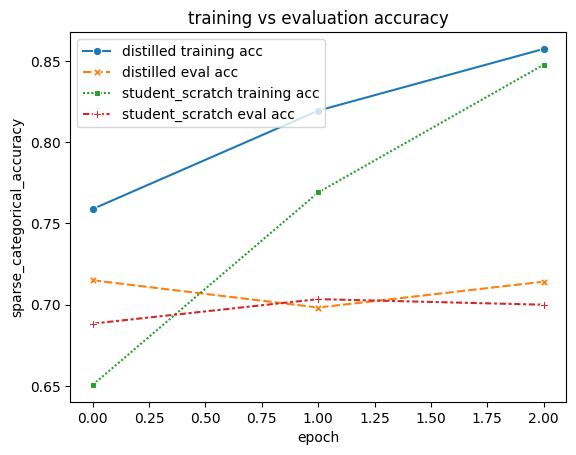

In [ ]:
# Get relevant metrics from history
def get_metrics(history):
  history = history.history
  acc = history['sparse_categorical_accuracy']
  val_acc = history['val_sparse_categorical_accuracy']
  return acc, val_acc

# Plot training and evaluation metrics given a dict of histories
def plot_train_eval(history_dict):

  metric_dict = {}

  for k, v in history_dict.items():
    acc, val_acc = get_metrics(v)
    metric_dict[f'{k} training acc'] = acc
    metric_dict[f'{k} eval acc'] = val_acc

  acc_plot = pd.DataFrame(metric_dict)
  acc_plot = sns.lineplot(data=acc_plot, markers=True)
  acc_plot.set_title('training vs evaluation accuracy')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel('sparse_categorical_accuracy')
  plt.show()

# plot for comparing the two student models
plot_train_eval({
    'distilled': distiller_history,
    'student_scratch': student_scratch_history
})
